In [1]:
import time
import pandas as pd
import geopandas
from math import sin, cos, sqrt, atan2, radians
from shapely.geometry import box
import ee
import folium
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.signal import find_peaks

In [2]:
class irrigation30():
    
    maxSample = 100000
    maxClusters_set = 2
    ndvi_lst = ['ndvi'+str(i).zfill(2) for i in range(1, 13)]
    
    def __init__(self, center_lat=43.771114, center_lon=-116.736866, edge_len=0.005, year=2018, resolution=30):
        
        if edge_len < 0.005:
            raise ValueError('Please select an edge length greater than or equal to 0.005 degree.')
            
        ee.Initialize()
        self.center_lat = center_lat
        self.center_lon = center_lon
        self.edge_len = edge_len
        self.year = year
        self.resolution = resolution
        self.label = []
        self.avg_ndvi = np.zeros((2, 12))
#         self.std_ndvi = np.zeros((2, 12))
        self.image = ee.Image()
        self.nClusters = 0
            
        self.aoi_ee = self.__create_bounding_box_ee()
        self.dist_lon = self.__calc_distance(self.center_lon-self.edge_len/2, self.center_lat, self.center_lon+self.edge_len/2, self.center_lat)
        self.dist_lat = self.__calc_distance(self.center_lon, self.center_lat-self.edge_len/2, self.center_lon, self.center_lat+self.edge_len/2)
        print('The selected area is approximately {:.2f} km by {:.2f} km'.format(self.dist_lon, self.dist_lat))
        
        est_total_pixels = round(self.dist_lat*self.dist_lon*(1000**2)/((self.resolution)**2))
        self.nSample = min(irrigation30.maxSample,est_total_pixels)
#         print('The estimated percentage of pixels used in the model is {:.0%}.'.format(self.nSample/est_total_pixels))


    def __create_bounding_box_ee(self):
        return ee.Geometry.Rectangle([self.center_lon-self.edge_len/2, self.center_lat-self.edge_len/2, self.center_lon+self.edge_len/2, self.center_lat+self.edge_len/2])
    
    def __create_bounding_box_shapely(self):
        return box(self.center_lon-self.edge_len/2, self.center_lat-self.edge_len/2, self.center_lon+self.edge_len/2, self.center_lat+self.edge_len/2)

    @staticmethod
    def __calc_distance(lon1, lat1, lon2, lat2):
            # Reference: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
            # approximate radius of earth in km
            R = 6373.0
            lon1 = radians(lon1)
            lat1 = radians(lat1)
            lon2 = radians(lon2)
            lat2 = radians(lat2)
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            distance = R * c
            return distance
        
    def __pull_Sentinel2_data(self):
        band_blue = 'B2' #10m
        band_green = 'B3' #10m
        band_red = "B4"  #10m
        band_nir = 'B8'  #10m   
        
        start_date = str(self.year)+'-1-01'
        end_date = str(self.year)+'-12-31'
        
        # Create image collection that contains the area of interest
        Sentinel_IC = (ee.ImageCollection('COPERNICUS/S2')
                         .filterDate(start_date, end_date)
                         .filterBounds(self.aoi_ee)
                         .select(band_nir, band_red))
        
        # # Get GFSAD30
        GFSAD30_IC = ee.ImageCollection("users/ajsohn/GFSAD30").filterBounds(self.aoi_ee)
        GFSAD30_img = GFSAD30_IC.max().clip(self.aoi_ee)

        def __calc_NDVI(img):
            ndvi = ee.Image(img.normalizedDifference([band_nir, band_red])).rename(["ndvi"]).copyProperties(img, img.propertyNames())
            composite = img.addBands(ndvi)
            return composite
        
        def __get_by_month_data(img):
            months = ee.List.sequence(1,12)
            byMonth = ee.ImageCollection.fromImages(
                months.map(lambda m: img.filter(ee.Filter.calendarRange(m, m, 'month')).median().set('month', m)
                          ).flatten())

            # Take all the satellite bands that have been split into months 
            # as different images in collection (byMonth), and merge into different bands
            def __mergeBands(image, previous):
                return ee.Image(previous).addBands(image).copyProperties(image, image.propertyNames())

            merged = byMonth.iterate(__mergeBands, ee.Image())
            return ee.Image(merged).select(['ndvi']+['ndvi_'+str(i) for i in range(1,12)],
                irrigation30.ndvi_lst)
        
        Sentinel_IC = Sentinel_IC.map(__calc_NDVI).select('ndvi')

        # ---------- GET MONTHLY DATA ---------
        # 2 = cropland, 0 - water, 1 = non-cropland, 3 = no-data
        byMonth_img = __get_by_month_data(Sentinel_IC) \
                        .addBands(GFSAD30_img.rename(['gfsad30'])) \
                        .addBands(ee.Image("USGS/GFSAD1000_V1").rename(['gfsad1000'])) \
                        .clip(self.aoi_ee)
    
        # Mask the non-cropland
        # 0 = water, 1 = non-cropland, 2 = cropland, 3 = 'no data'
        cropland = byMonth_img.select('gfsad30').eq(2)
        byMonth_img_masked = byMonth_img.mask(cropland)
#         non_cropland = byMonth_img.select('gfsad30').lt(2) or byMonth_img.select('gfsad30').gt(2)
#         non_cropland = non_cropland.mask(non_cropland)

        return byMonth_img_masked

    def __pull_TerraClimate_data(self, band, label, multiplier=1):       
        start_date = str(self.year)+'-1-01'
        end_date = str(self.year)+'-12-31'
        
        # Create image collection that contains the area of interest
        TerraClimate_IC = (ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")
                         .filterDate(start_date, end_date)
                         .filterBounds(self.aoi_ee)
                         .select(band))
        
        def __get_by_month_data(img):
            months = ee.List.sequence(1,12)
            byMonth = ee.ImageCollection.fromImages(
                months.map(lambda m: img.filter(ee.Filter.calendarRange(m, m, 'month')).median().set('month', m)
                          ).flatten())

            # Take all the satellite bands that have been split into months 
            # as different images in collection (byMonth), and merge into different bands
            def __mergeBands(image, previous):
                return ee.Image(previous).addBands(image).copyProperties(image, image.propertyNames())

            merged = byMonth.iterate(__mergeBands, ee.Image())
            return ee.Image(merged).select([band]+[band+'_'+str(i) for i in range(1,12)],
                [band+str(i).zfill(2) for i in range(1, 13)])

        # ---------- GET MONTHLY DATA ---------
        # 2 = cropland, 0 - water, 1 = non-cropland, 3 = no-data
        byMonth_img = __get_by_month_data(TerraClimate_IC).clip(self.aoi_ee)

        pr_dict = byMonth_img.reduceRegion(reducer=ee.Reducer.mean(), geometry=self.aoi_ee, maxPixels=1e13, scale=self.resolution).getInfo()
        pr_df = pd.DataFrame([pr_dict], columns=[band+str(i).zfill(2) for i in range(1, 13)], index=[label])
        pr_arr = pr_df.to_numpy()*multiplier
        fig, ax = plt.subplots(figsize=(12, 6))
        plt.plot(pr_arr[0], label=label)
        plt.legend()
        
    def plot_precipitation(self):
        self.__pull_TerraClimate_data('pr', 'Precipitation')
        
    def plot_temperature_max(self):
        self.__pull_TerraClimate_data('tmmx', 'Max Temperature', multiplier=0.1)

    def fit_predict(self):

        self.image = self.__pull_Sentinel2_data()

        training_FC = self.image \
                    .select(irrigation30.ndvi_lst) \
                    .sample(region=self.aoi_ee, scale=self.resolution, numPixels=self.nSample)
        
        maxClusters_set = 2
        # Instantiate the clusterer and train it.
#         clusterer = ee.Clusterer.wekaKMeans(irrigation30.maxClusters_set).train(training_FC, inputProperties=irrigation30.ndvi_lst)
        clusterer = ee.Clusterer.wekaCascadeKMeans(minClusters=2, maxClusters=irrigation30.maxClusters_set).train(training_FC, inputProperties=irrigation30.ndvi_lst)
        # wekaXMeans outputs the same number of clusters but different mixes when maxClusters is set differently
#         clusterer = ee.Clusterer.wekaXMeans(minClusters=2, maxClusters=irrigation30.maxClusters_set).train(training_FC, inputProperties=irrigation30.ndvi_lst)

        # Cluster the input using the trained clusterer.
        cluster_result = self.image.cluster(clusterer)
        
        cluster_output = dict()
        for i in range(0, maxClusters_set):
            print('Averaging NDVIs for Cluster {}...'.format(i))
            cluster_output[i] = self.image.select(irrigation30.ndvi_lst).mask(cluster_result.select('cluster').eq(i)).reduceRegion(reducer=ee.Reducer.mean(), geometry=self.aoi_ee, maxPixels=1e13, scale=30).getInfo()
            if cluster_output[i]['ndvi01']==None:
                self.nClusters = i
                del cluster_output[i]
                break
            elif i == maxClusters_set-1:
                self.nClusters = maxClusters_set
        
        # Reference: https://stackoverflow.com/questions/45194934/eval-fails-in-list-comprehension
        globs = globals()
        locs = locals()
        cluster_df = pd.DataFrame([eval('cluster_output[{}]'.format(i), globs, locs) for i in range(0,self.nClusters)], columns=irrigation30.ndvi_lst, index=['Cluster_'+str(i) for i in range(0,self.nClusters)])

        self.avg_ndvi = cluster_df.to_numpy()
        cluster_mean = self.avg_ndvi.mean(axis=1)
        if self.nClusters == 2:
            if cluster_mean[0] < cluster_mean[1]:
                self.image = self.image.addBands(ee.Image(cluster_result.select('cluster')).rename('prediction'))
                self.label = ["Rainfed", "Irrigated"]
            else:
                self.image = self.image.addBands(ee.Image(cluster_result.expression('1-c',{'c':cluster_result.select('cluster')})).rename('prediction'))
                self.label = ["Irrigated", "Rainfed"]
        else:
            self.image = self.image.addBands(ee.Image(cluster_result.select('cluster')).rename('prediction'))
            self.label = ['Cluster_'+str(i) for i in range(0,self.nClusters)]
        
#         print('Calculating standard deviation of NDVIs for Cluster 0...')
#         cluster_0_dict = self.image.select(irrigation30.ndvi_lst).mask(cluster_result.select('cluster').eq(0)).reduceRegion(reducer=ee.Reducer.stdDev(), geometry=self.aoi_ee, maxPixels=1e13, scale=self.resolution).getInfo()
#         print('Calculating standard deviation of NDVIs for Cluster 1...')
#         cluster_1_dict = self.image.select(irrigation30.ndvi_lst).mask(cluster_result.select('cluster').eq(1)).reduceRegion(reducer=ee.Reducer.stdDev(), geometry=self.aoi_ee, maxPixels=1e13, scale=self.resolution).getInfo()
#         cluster_df = pd.DataFrame([cluster_0_dict, cluster_1_dict], columns=irrigation30.ndvi_lst, index=['Cluster_0', 'Cluster_1'])
#         self.std_ndvi = cluster_df.to_numpy()
        
        print('Model complete')
        
    def plot_map(self):
        def add_ee_layer(self, ee_object, vis_params, show, name):
            try:    
                if isinstance(ee_object, ee.image.Image):    
                    map_id_dict = ee.Image(ee_object).getMapId(vis_params)
                    folium.raster_layers.TileLayer(
                        tiles = map_id_dict['tile_fetcher'].url_format,
                        attr = 'Google Earth Engine',
                        name = name,
                        overlay = True,
                        control = True,
                        show = show
                        ).add_to(self)
                elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
                    ee_object_new = ee_object.median()
                    map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
                    folium.raster_layers.TileLayer(
                        tiles = map_id_dict['tile_fetcher'].url_format,
                        attr = 'Google Earth Engine',
                        name = name,
                        overlay = True,
                        control = True,
                        show = show
                        ).add_to(self)
                elif isinstance(ee_object, ee.geometry.Geometry):    
                    folium.GeoJson(
                            data = ee_object.getInfo(),
                            name = name,
                            overlay = True,
                            control = True
                        ).add_to(self)
                elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
                    ee_object_new = ee.Image().paint(ee_object, 0, 2)
                    map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
                    folium.raster_layers.TileLayer(
                            tiles = map_id_dict['tile_fetcher'].url_format,
                            attr = 'Google Earth Engine',
                            name = name,
                            overlay = True,
                            control = True,
                            show = show
                        ).add_to(self)

            except:
                print("Could not display {}".format(name))

        # Add EE drawing method to folium.
        folium.Map.add_ee_layer = add_ee_layer

        myMap = folium.Map(location=[self.center_lat, self.center_lon], zoom_start=8)
        aoi_shapely = self.__create_bounding_box_shapely()
        folium.GeoJson(aoi_shapely, name="Area of Interest").add_to(myMap)
        visParams = {'min':0, 'max':1, 'palette': ['yellow', 'green']}
        myMap.add_ee_layer(self.image.select('prediction'), visParams, show=True, name='Prediction')
        #     0: Non-croplands (black)
        #     1: Croplands: irrigation major (green)
        #     2: Croplands: irrigation minor (lighter green)
        #     3: Croplands: rainfed (yellow)
        #     4: Croplands: rainfed, minor fragments (yellow orange)
        #     5: Croplands: rainfed, rainfed, very minor fragments (orange)
        visParams = {'min':0, 'max':5, 'palette':['black', 'green', 'a9e1a9', 'yellow', 'ffdb00', '#ffa500']}
        myMap.add_ee_layer(self.image.select('gfsad1000'), visParams, show=False, name='GFSAD1000')
        visParams = {'min':0, 'max':1, 'palette': ['red', 'yellow', 'green']}
        for i in range(1, 13):
            temp_band = 'ndvi'+str(i).zfill(2) 
            myMap.add_ee_layer(self.image.select(temp_band), visParams, show=False, name=temp_band)
        myMap.add_child(folium.LayerControl())

        return myMap
    
    def plot_avg_ndvi(self):
        fig, ax = plt.subplots(figsize=(12, 6))
        if self.nClusters == 2:
            plt.plot(self.avg_ndvi[0], label=self.label[0])
            plt.plot(self.avg_ndvi[1], label=self.label[1])
        else:
            for i in range(0, self.nClusters):
                plt.plot(self.avg_ndvi[i], label='Cluster_'+str(i))
        plt.legend()

    def __smooth(self, y_raw):
        y = np.concatenate((y_raw, y_raw, y_raw))
        x = np.linspace(0, 35, num=36, endpoint=True)
        xnew = np.linspace(0, 35, num=141, endpoint=True)
        f_interp = interp1d(x, y, kind='cubic')
        y_interp = f_interp(xnew)
        y_loess = savgol_filter(y_interp, 7, 1)
        peak_index, peak_value = find_peaks(y_loess, height=0)
        # Intermediate graph
        # plt.plot(x, y, 'o', xnew, y_loess, '--')
        # plt.plot(xnew[peak_index], peak_value['peak_heights'], "x")
        # plt.legend(['data', 'smooth'], loc='best')
        # plt.show()
        # Final graph
        final_peak_index = [i - 12 for i in xnew[peak_index] if i >= 12 and i < 24]
        print(final_peak_index)
        final_peak_value = [j for i, j in zip(xnew[peak_index], peak_value['peak_heights']) if i >= 12 and i < 24]
        final_x = [i - 12 for i in xnew if i >= 12 and i < 24]
        final_y_loess = [j for i, j in zip(xnew, y_loess) if i >= 12 and i < 24]
        return final_x, final_y_loess, final_peak_index, final_peak_value
        
    def predict_crop_season(self):
        if self.label[0] == 'Irrigated':
            y_raw = self.avg_ndvi[0] - self.avg_ndvi[1]
        else:
            y_raw = self.avg_ndvi[1] - self.avg_ndvi[0]

        fig, ax = plt.subplots(figsize=(12, 6))
        y_raw = self.avg_ndvi[0]
        final_x, final_y_loess, final_peak_index, final_peak_value = self.__smooth(y_raw)
        plt.plot(range(0,12), y_raw, 'o', final_x, final_y_loess, '--')
        plt.plot(final_peak_index, final_peak_value, "x")
        y_raw = self.avg_ndvi[1]
        final_x, final_y_loess, final_peak_index, final_peak_value = self.__smooth(y_raw)
        plt.plot(range(0,12), y_raw, 'o', final_x, final_y_loess, '--')
        plt.plot(final_peak_index, final_peak_value, "x")
#         plt.legend(['Diff in NDVI', 'Smooth'], loc='best')

In [3]:
# (lon, lat)
# [82.121452, 21.706688],     // C01 (India): Doesn't look quite right.
                                              # Agree; the division feel arbitrary; both matched precipitation trend though
# [-94.46643, 48.76297],      // C02 (Canada): S2-Q1+Q4 layer is white/black. "Satellite" looks better. Irrigation is okay.
# [-105.69772, 49.316722],    // C03 (Canada): SWAP OUT WITH IDAHO.
# [10.640815, 52.185072],     // C04 (Germany): Strange S2 layers, otherwise good result. Look at flip of cropland in Q2 and Q3! Irrigation seems to coincide with Q2. 
#                                             # (one in May and the other in July) One rainfed and one irrigation or both irrigation?
# [10.7584699, 52.2058339],   // C05 (Germany): Doesn't seem right. 
# [33.857852, 46.539389],     // C06 (Ukraine): WEIRD RESULT. S2 seasonal flip-flops (Q2 and Q3 flip flop, then Q4 confusion). NDVI peaks at different seasons for each cluster. Heuristic mismatch!
#                                             # Maybe both are irrgated but at different times (April, July, and October), 3 clusters?
# [36.58565, 47.0838],        // C07 (Ukraine): Looks okay?
# [38.34523, 30.22176],       // C08 (Saudi Arabia): Looks great. Although definitely depends on season.
# [-64.075199, -31.950112],   // C09 (Argentina): NEW. Irrigation labels make no sense. Clusters have almost identical signatures.
# [67.359826, 43.55412],      // C10 (Uzbekistan): Mostly good. Although clusters seem to select areas that peak at different seasons (Q2 vs Q3). 
# [-46.2607, -11.93067]       // C11 (Brazil): Tricky case. Mostly non-cropland. 
# [-116.736866, 43.771114]    // Idaho

In [4]:
# Ukraine
# test = irrigation30(center_lat=46.539389, center_lon=33.857852, edge_len=0.05)

In [5]:
# Indian - compared against GFSAD30+ (GFSAD30+ marked some villedge areas as irrigated)
# test = irrigation30(center_lat=21.628880, center_lon=85.585623, edge_len=0.05)

In [6]:
# Indian - 2 crop (Lorenzo: Jan is irrigated for both clusters; Julyone irrigation, one rainfed | one cluster is more irrigated than the other cluster?)
# test = irrigation30(center_lat=23.58014, center_lon=73.28559, edge_len=0.05)

The selected area is approximately 5.10 km by 5.56 km


In [7]:
# Germary - (one in May and the other in July) One rainfed and one irrigation or both irrigation?
# test = irrigation30(center_lat=52.185072, center_lon=10.640815, edge_len=0.05)

In [8]:
test = irrigation30(center_lat=10.716019771291887, center_lon=105.50046138315179, edge_len=0.05)

The selected area is approximately 5.46 km by 5.56 km


In [9]:
%%time
test.fit_predict()

Averaging NDVIs for Cluster 0...
Averaging NDVIs for Cluster 1...
Model complete
CPU times: user 50 ms, sys: 10 ms, total: 60 ms
Wall time: 1min 35s


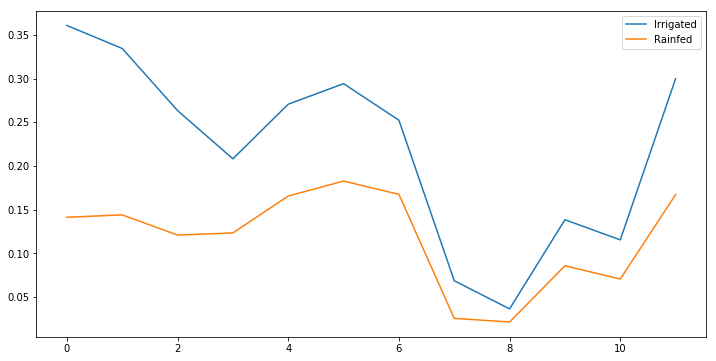

In [10]:
test.plot_avg_ndvi()
# 0.3?

In [11]:
# test.predict_crop_season()

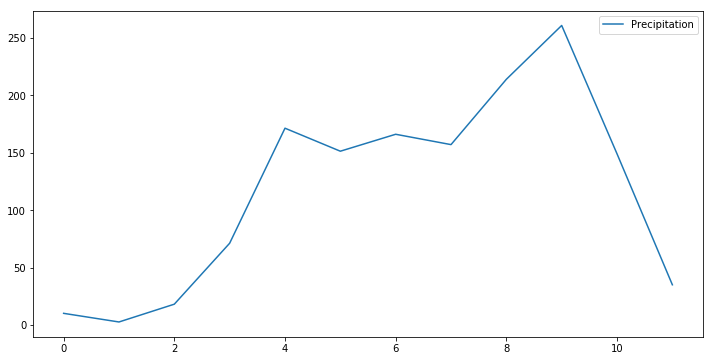

In [12]:
test.plot_precipitation()
# peak but too low? 800~600/4 = 200, at least 100mm. 5-6mm per day

In [13]:
%%time
test.plot_map()

CPU times: user 160 ms, sys: 20 ms, total: 180 ms
Wall time: 1min 8s


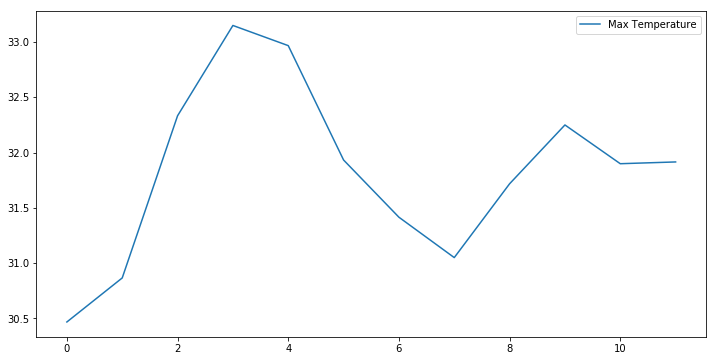

In [14]:
test.plot_temperature_max()
# appropriate temperature for crop? 15-35? Use Avg temperature

In [15]:
test.nClusters

2